<!-- Autogenerated by `scripts/make_examples.py` -->
<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/voxel51/fiftyone-examples/blob/master/examples\openvino-detection-with-fiftyone.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791629-6e618700-5769-11eb-857f-d176b37d2496.png" height="32" width="32">
            Try in Google Colab
        </a>
    </td>
    <td>
        <a target="_blank" href="https://nbviewer.jupyter.org/github/voxel51/fiftyone-examples/blob/master/examples\openvino-detection-with-fiftyone.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791634-6efa1d80-5769-11eb-8a4c-71d6cb53ccf0.png" height="32" width="32">
            Share via nbviewer
        </a>
    </td>
    <td>
        <a target="_blank" href="https://github.com/voxel51/fiftyone-examples/blob/master/examples\openvino-detection-with-fiftyone.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791633-6efa1d80-5769-11eb-8ee3-4b2123fe4b66.png" height="32" width="32">
            View on GitHub
        </a>
    </td>
    <td>
        <a href="https://github.com/voxel51/fiftyone-examples/raw/master/examples\openvino-detection-with-fiftyone.ipynb" download>
            <img src="https://user-images.githubusercontent.com/25985824/104792428-60f9cc00-576c-11eb-95a4-5709d803023a.png" height="32" width="32">
            Download notebook
        </a>
    </td>
</table>


# Horizontal Text Detection with OpenVino Model using FiftyOne tool

This notebook is a demonstration of the usage of Intel's OpenVino [horizontal text detections model](https://docs.openvino.ai/latest/omz_models_model_horizontal_text_detection_0001.html) for the horizontal text detection on [Total Text Dataset](https://www.kaggle.com/datasets/ipythonx/totaltextstr) with the help of the open source tool [FiftyOne](https://docs.voxel51.com/index.html). 
The notebook goes through the steps of loading the dataset of images with groundtruth detections into FiftyOne, visualizing the images and adding predictions from the model and evaluating those predictions against the ground truth

### Prequisites
   - Get the [Total Text Dataset](https://www.kaggle.com/datasets/ipythonx/totaltextstr) downloaded in the same path where you have 
   where you have the notebook
   - Run the below code cell to get the required python libraries

In [ ]:
# !pip install fiftyone
# !pip install cv2
# !pip install openvino
# !pip install numpy
# !pip install wget

## Imports 

In [1]:
import fiftyone as fo
import os
import glob
import cv2
import re
import numpy as np
import wget
from openvino.runtime import Core

## Total-Text Dataset
The Total-Text folder contains three folders: 
   - Train
   - Test
   - Annotation

To add samples to the dataset, we are going to loop through the images in the Train and Test folders and use the ground_truth_polygonal annotations text files to get the ground truth bounding box detections and labels. There are other groundtruths available in the Annotation folder such as character level and text region mask which user can use based on their model evaluation. For the purpose of this notebook, we are looking at the horizontal bounding box text detection.

## Load dataset into FiftyOne

In [ ]:
# Create samples for your data
samples = []
for dataname in ['Train', 'Test']:
    
    # Looping through the Train and Test folder paths to add samples to the dataset
    images_patt = "./Total-Text/"+dataname+"/*"
    
    for filepath in glob.glob(images_patt):
        
        # Creating image samples with their respective sample tags, Train or Test 
        # Tags gives you flexibility to use only samples present in Train  or Test data
        sample = fo.Sample(filepath=filepath,tags=[dataname])
        
        # Get height, width of image
        img = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
        height = img.shape[0]
        width = img.shape[1]
        
        # Getting the filename from the filepath using the split operation
        # Ex: img1001 from Train folder image file path './Total-Text/Test\\img1.jpg'
        # Check the separator for the first split based on the OS
        filename=filepath.split("\\")[-1].split(".")[0]
        
        # List of test images that are avoided due to incorrect formatting of their polygonal annnotations .txt file
        # The correct polygonal annotations format should be 
        # "x: [[153 161 179 195 184 177]], y: [[347 323 305 315 331 357]], ornt: [u'c'], transcriptions: [u'the']\n"
        test_images_to_avoid=['img551','img621','img623']
        
        if filename not in test_images_to_avoid:
            
            # Path to polygonal annotation text file
            annotation_path="./Total-Text/Annotation/groundtruth_polygonal_annotation/"+dataname+"/poly_gt_"+filename+".txt"
            
            with open(annotation_path, "r") as f:
                
                # Each polygonal annotation text file is read line by line
                # For each line we try to extract key-value pairs using regular expressions python library
                # x and y are coordinates for bounding boxes, ornt is the orientation of the text
                # transcription gives us the text value detected
                polylines = []               
                lines = f.readlines()
                
                for line in lines:
                
                    # Using the findall function of the re library we extract the values of 
                    # x, y, ornt, and transcriptions by pattern matching
                    # For example, for x and y we are looking for number using \d
                    # for ornt and transcription we are matching with alphabets both
                    # small and Capital as well as '#' in some cases 
                    x = re.findall(r'\d+\.\d+|\d+', line.split(',')[0])
                    y = re.findall(r'\d+\.\d+|\d+', line.split(',')[1])
                    
                    # In case of ornt and transcription, we have an extra check where there are no
                    # values or its empty
                    if(len(re.findall(r'[a-z]+|\#', line.split(',')[2])))==3:
                        ornt = re.findall(r'[a-z]+|\#', line.split(',')[2])[2]
                    else:
                        ornt = "no_value" 
                    if(len(re.findall(r'[A-Za-z]+|\#|\d+', line.split(',')[3])))==3:
                        transcriptions = re.findall(r'[A-Za-z]+|\#|\d+', line.split(',')[3])[2]
                    else:
                        transcriptions = "no_label"
                        
                    # normalize x and y values between 0 and 1 using the image height and width
                    x = [round(float(i)/width, 2) for i in x]
                    y = [round(float(i)/height, 2) for i in y]
                    
                    # get in the format of lists of lists of tuples
                    points = [list(zip(x, y))]
                    
                    # Create polyline label
                    polyline=fo.Polyline(points=points,closed=True)
                    # In case of evaluating model that detects text label, you can modify the above code
                    # by adding label parameter to the fo.PolyLine method as label=transcriptions. 
                    # The other way around in the absence of labels for both groundtruths and model 
                    # predictions is to use an arbitrary label such as label='detected'
                    
                    polylines.append(polyline)
            
            # Adding polyline labels for each samples
            sample["ground_truth_polylines"] = fo.Polylines(polylines=polylines)
            # Adding groundtruth labels with bounding box representation 
            # tighly enclosing the polylines
            sample["ground_truth"] = sample["ground_truth_polylines"].to_detections()
            samples.append(sample)
            
# Create dataset
dataset = fo.Dataset("Total-Text-dataset-FO-1")
dataset.add_samples(samples)    

## Launch the fiftyone app to view the dataset


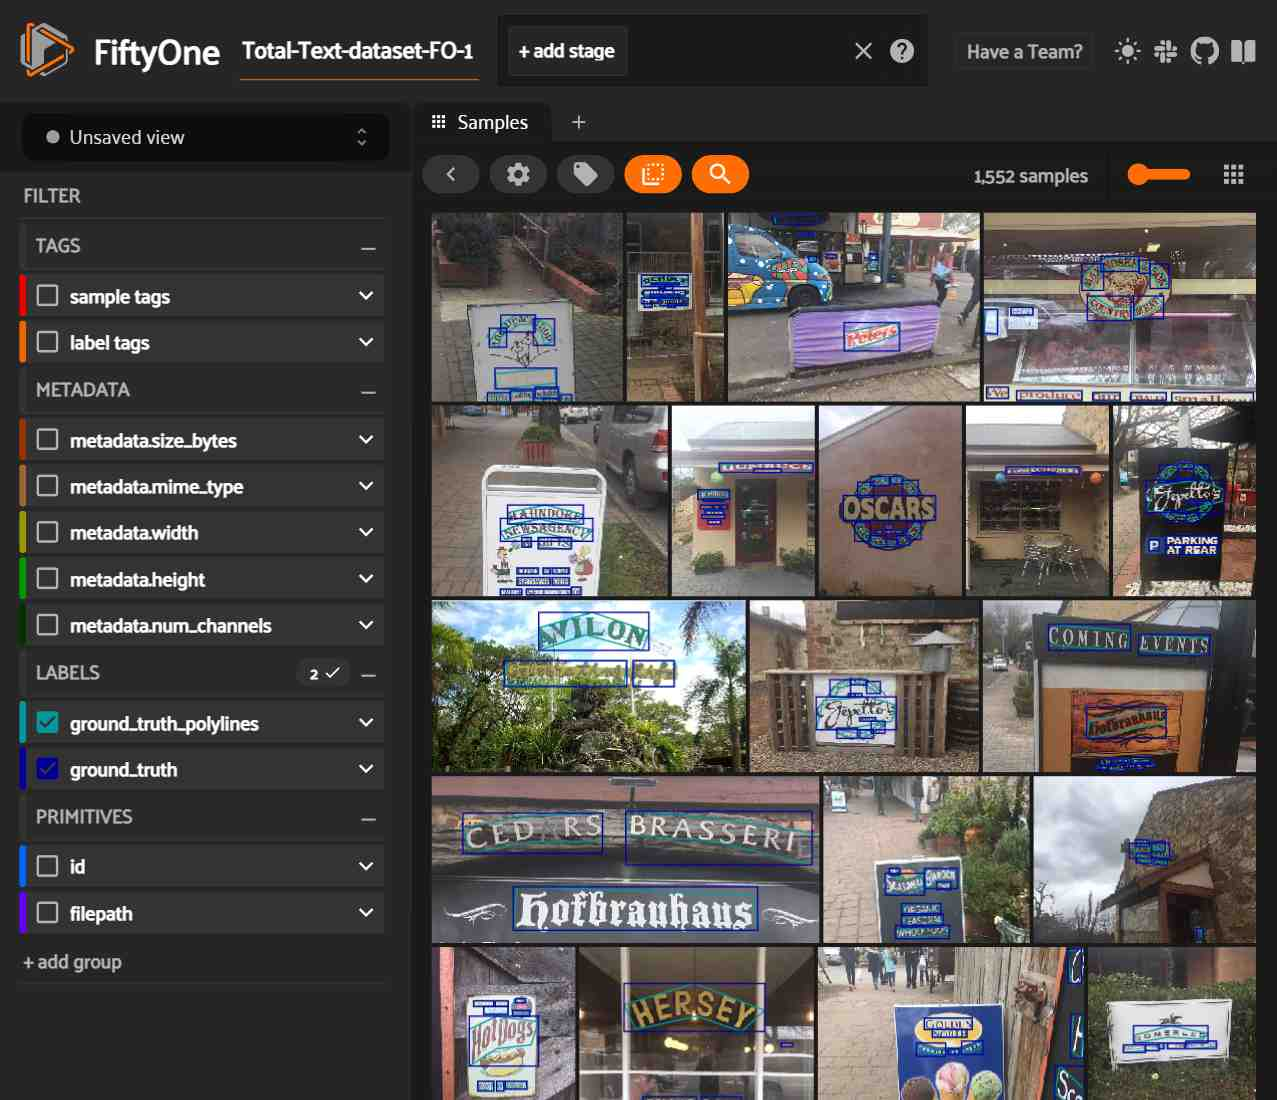

In [4]:
session = fo.launch_app(dataset=dataset)

In [5]:
# Print some information about the dataset
print(dataset)

Name:        Total-Text-dataset-FO-1
Media type:  image
Num samples: 1552
Persistent:  False
Tags:        []
Sample fields:
    id:                     fiftyone.core.fields.ObjectIdField
    filepath:               fiftyone.core.fields.StringField
    tags:                   fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:               fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth_polylines: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Polylines)
    ground_truth:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [6]:
# Print a ground truth detection
sample = dataset.first()
print(sample.ground_truth.detections[0])

<Detection: {
    'id': '646e4caddaa7b9101742894a',
    'attributes': {},
    'tags': [],
    'label': None,
    'bounding_box': [0.3, 0.61, 0.09000000000000002, 0.09999999999999998],
    'mask': None,
    'confidence': None,
    'index': None,
}>


## Add predictions to dataset

In [7]:
# predictions_view = dataset.match_tags(["Train", "Test"]) # for whole dataset
predictions_view = dataset.match_tags(["Test"]) # for test dataset

## Get the OpenVino Model

An OpenVINO IR (Intermediate Representation) model consists of an .xml file, containing information about network topology, and a .bin file, containing the weights and biases binary data. The read_model() function expects the .bin weights file to have the same filename and be located in the same directory as the .xml file.

In [ ]:
# Get the current working directory
cwd = os.path.abspath(os.getcwd())

# Create a new directory named 'model'
os.mkdir(cwd+'/model')

# Define the source urls
model_xml_url = 'https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/004-hello-detection/model/horizontal-text-detection-0001.xml'
model_bin_url = 'https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/004-hello-detection/model/horizontal-text-detection-0001.bin?raw=true'

# Define the destination file paths
xml_path = cwd+'/model/horizontal-text-detection-0001.xml'
bin_path = cwd+'/model/horizontal-text-detection-0001.bin'

# Download the files to their respective paths
wget.download(model_xml_url, out = xml_path)
wget.download(model_bin_url, out = bin_path)

### Let's load the OpenVino model

In [8]:
ie = Core()

model = ie.read_model(model="./model/horizontal-text-detection-0001.xml")
compiled_model = ie.compile_model(model=model, device_name="CPU")

input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output("boxes")

### Add predictions to samples

In [9]:
with fo.ProgressBar() as pb:
    for sample in pb(predictions_view):
        # Text detection models expect an image in BGR format.
        img = cv2.imread(sample.filepath)

        # height, width of image
        height = img.shape[0]
        width = img.shape[1]
        # N,C,H,W = batch size, number of channels, height, width.
        N, C, H, W = input_layer_ir.shape

        # Resize the image to meet network expected input sizes.
        resized_image = cv2.resize(img, (W, H))

        # Reshape to the network input shape.
        input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)
        
        # Create an inference request.
        boxes = compiled_model([input_image])[output_layer_ir]

        # Remove zero only boxes.
        boxes = boxes[~np.all(boxes == 0, axis=1)]
        
        # Getting the ratio of resized images and original image to avoid getting bounding boxes at wrong location
        (real_y, real_x), (resized_y, resized_x) = img.shape[:2], resized_image.shape[:2]
        ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

        # Convert detections to FiftyOne format
        detections = []
        for i in range(len(boxes)):
            # Convert float to int and multiply corner position of each box by x and y ratio.
            # If the bounding box is found at the top of the image, 
            # position the upper box bar little lower to make it visible on the image. 
            (x1, y1, x2, y2) = [
                int(max(corner_position * ratio_y, 10)) if idx % 2 
                else int(corner_position * ratio_x)
                for idx, corner_position in enumerate(boxes[i][:-1])
            ]
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            rel_box = [x1 / width, y1 / height, (x2 - x1) / width, (y2 - y1) / height]
            detections.append(
                fo.Detection(    
                bounding_box=rel_box,  
                confidence=boxes[i][4]
                )
            )
        sample["horizontal_detection"] = fo.Detections(detections=detections)
        sample.save()  

 100% |█████████████████| 297/297 [19.2s elapsed, 0s remaining, 15.9 samples/s]      



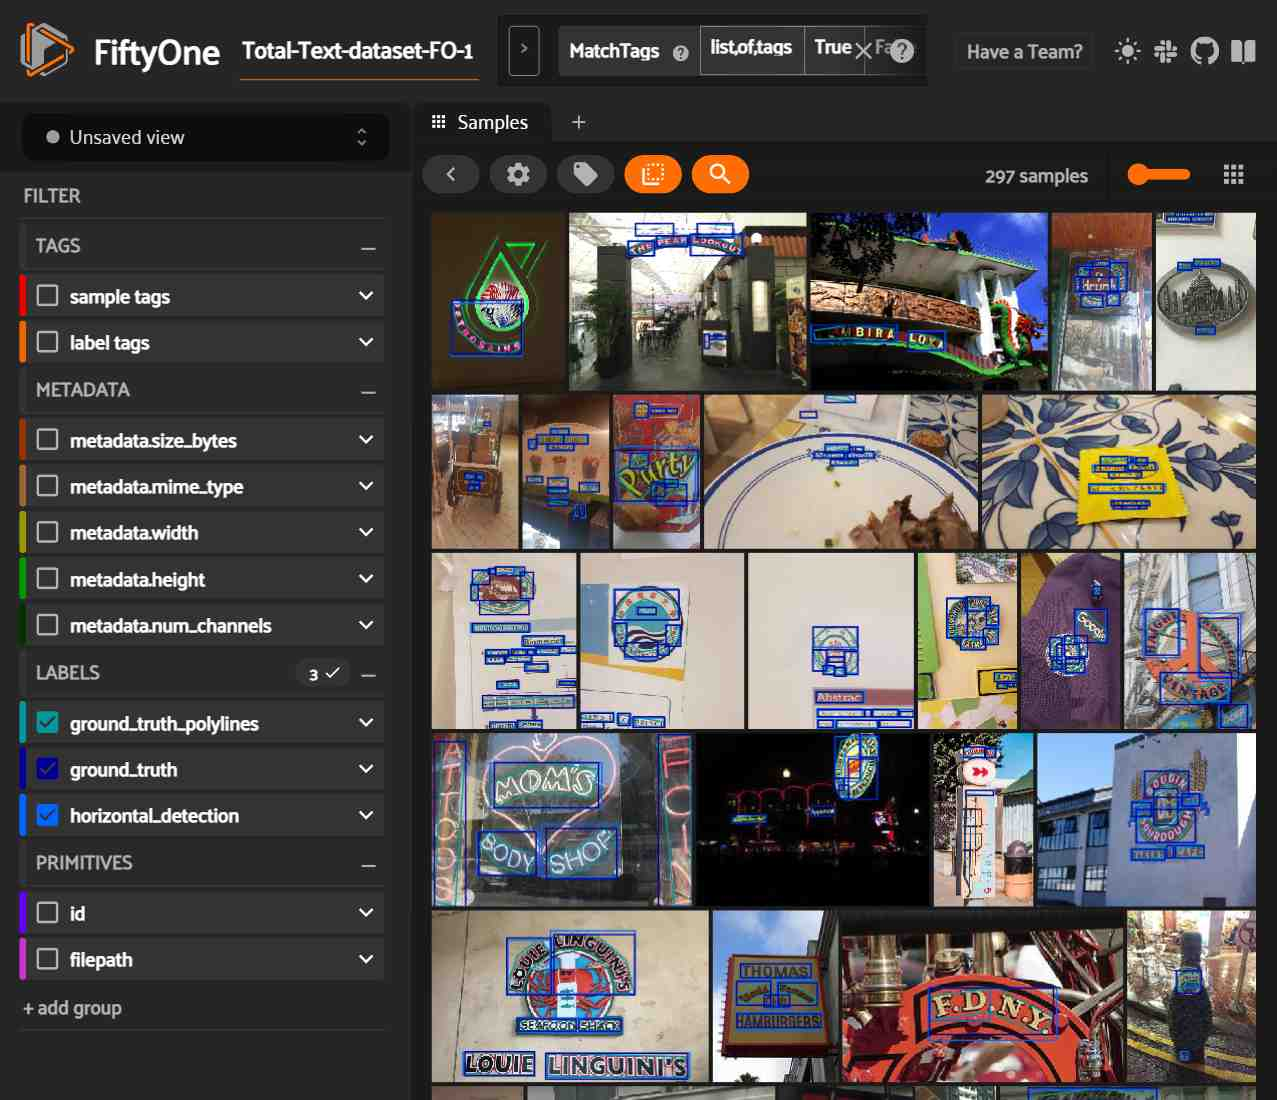

In [10]:
session.view = predictions_view

### Check the detections


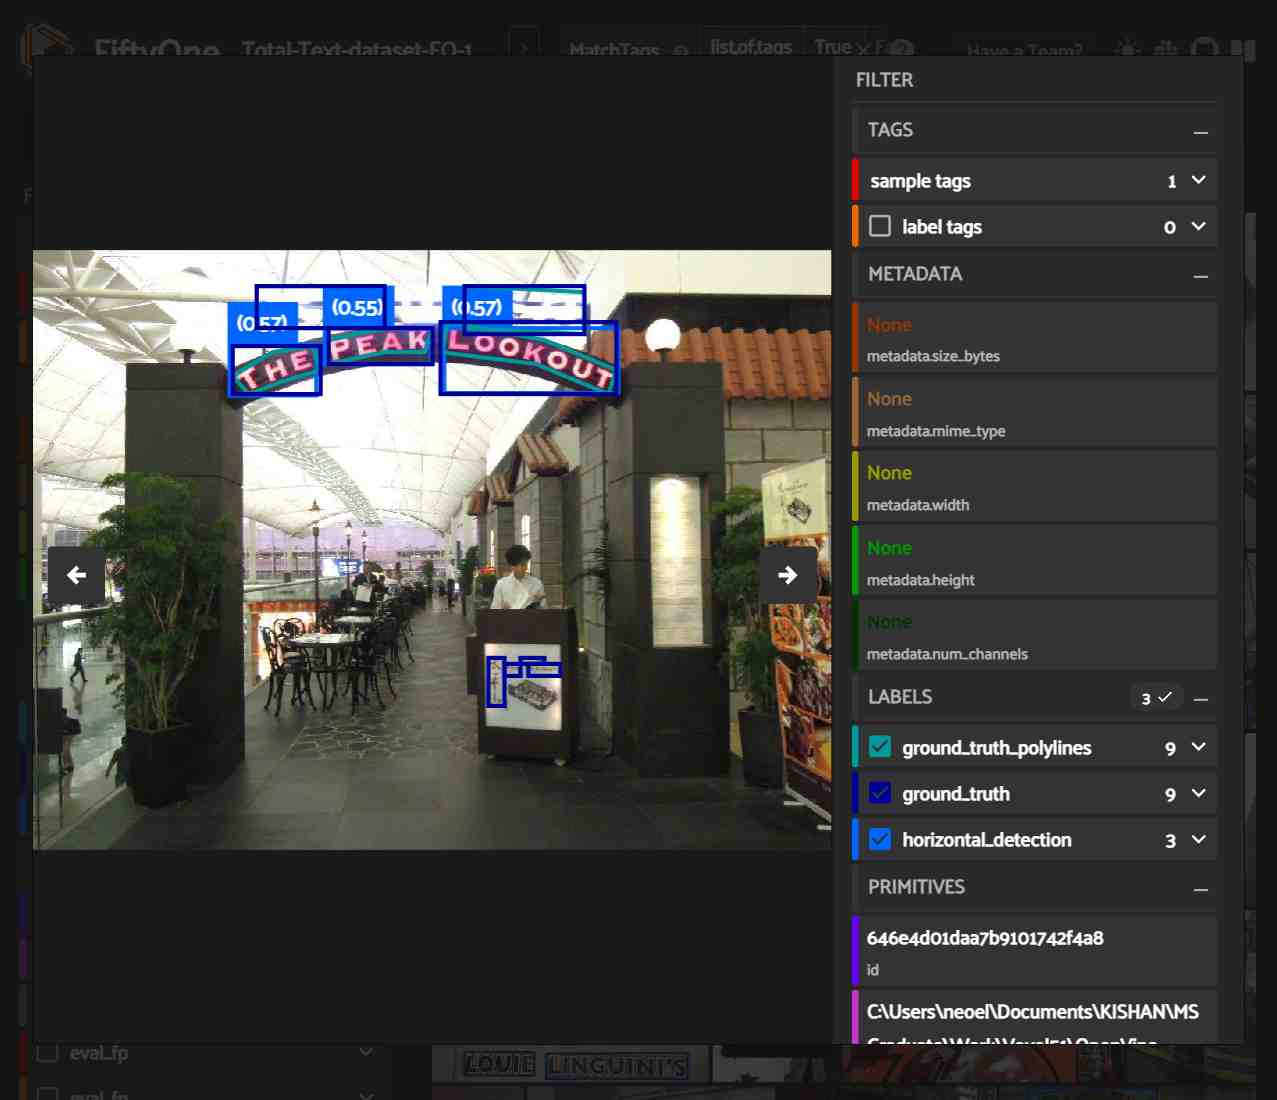

In [11]:
session.show()

## Evaluate detections

In [12]:
results = predictions_view.evaluate_detections(
    "horizontal_detection", gt_field="ground_truth",use_boxes=True, classwise=False, eval_key="eval"
)

Evaluating detections...
 100% |█████████████████| 297/297 [9.0s elapsed, 0s remaining, 39.4 samples/s]      


The OpenVino's horizontal detection model only detects bounding box but return label for the text detected, therefore, while evaluating detection using `evaluate_detection` function, the `classwise` parameter is set to `False` and also ground_truth labels for text detected are not added to dataset. For a model that returns label for text detected, you can set `classwise` to `True` and add the ground truth labels to dataset.

In [13]:
# Convert to evaluation patches
eval_patches = dataset.to_evaluation_patches("eval")
print(eval_patches)

Dataset:     Total-Text-dataset-FO-1
Media type:  image
Num patches: 13422
Patch fields:
    id:                   fiftyone.core.fields.ObjectIdField
    sample_id:            fiftyone.core.fields.ObjectIdField
    filepath:             fiftyone.core.fields.StringField
    tags:                 fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:             fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    horizontal_detection: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    crowd:                fiftyone.core.fields.BooleanField
    type:                 fiftyone.core.fields.StringField
    iou:                  fiftyone.core.fields.FloatField
View stages:
    1. ToEvaluationPatches(eval_key='eval', config=None)


In [14]:
print(eval_patches.count_values("type"))

{None: 10589, 'fp': 303, 'fn': 580, 'tp': 1950}


In [15]:
# View patches in the App
session.view = eval_patches